In [1]:
from sklearn.model_selection import KFold
import pickle
import pandas as pd
import os.path
file_name = 'resampled_2x5_cross_validation'
if os.path.isfile(file_name+'.pickle'): 
    with open(file_name+'.pickle', 'rb') as handle:
        train_folds,test_folds = pickle.load(handle)  

In [2]:
import torch
import torch.nn as nn

class DNNs(torch.nn.Module):
    def __init__(self, device, input_dim=64, output_dim = 251, num_dnn=4, loss_weights=None):
        super().__init__()

        if loss_weights is None:
            weight = 1 / (2 * (num-1))
            loss_weights = [weight] * (num-1)
            loss_weights.append(1/2)
        self.device = device
        self.to(device)
        self.loss_weights = loss_weights
        self.dnn_list = nn.ModuleList([DNN(input_dim + i * output_dim if i == 0 else input_dim + output_dim).to(device) for i in range(num_dnn)])
        self.num_dnn = num_dnn
    
    def forward(self, x):
        x = x.to(self.device)
        dnn_outputs = []
        for i in range(self.num_dnn):
            if i == 0:
                y = self.dnn_list[i](x)
                dnn_outputs.append(y)
                y = torch.cat((x, y), -1)
            else:
                y = self.dnn_list[i](y)
                dnn_outputs.append(y)
                y = torch.cat((x, y), -1)
        return dnn_outputs
    
    def calculate_loss(self, dnn_outputs, true_y):
        loss = 0
        for i in range(self.num_dnn):
            mse_loss = nn.MSELoss()(dnn_outputs[i], true_y)
            loss += mse_loss * self.loss_weights[i]
        return loss

class DNN(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.relu  = nn.ReLU()
        self.linear1 = torch.nn.Linear(input_dim, 512)
        self.linear2 = torch.nn.Linear(512, 512)
        self.linear3= torch.nn.Linear(512, 250)
        self.dnn = nn.Sequential(
            self.linear1,
            self.relu,
            self.linear2,
            self.relu,
            self.linear3
        )
    def forward(self, x):
        y = self.dnn(x)
        y = torch.sigmoid(y)
        return y


In [3]:
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
from tqdm import tqdm
class CalculateMSE():
    def __init__(self, net,n_epochs,batch_size ):
        super().__init__()
        self.net = net
        #initialize some constants
        self.batch_size = batch_size
        self.learning_rate = 1e-4
        self.n_epochs = n_epochs
        self.net.apply(self.weights_init)   
    def weights_init(self,layer):
        if type(layer) == nn.Linear:
            nn.init.orthogonal_(layer.weight)
    def get_mse(self,train_data, train_label, test_data, test_label):
        train_set = torch.utils.data.TensorDataset(
            torch.Tensor(train_data), 
            torch.Tensor(train_label))
        val_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data), 
            torch.Tensor(test_label))
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)
        tloss = []
        vloss = []
        criterion = nn.MSELoss()
        criterion_weighted = self.net.calculate_loss
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate,weight_decay=5e-5)
        with tqdm(range(0, self.n_epochs)) as pbar:
            for epoch in pbar:
                epoch_train_loss=[]
                for i, data in enumerate(train_loader, 0):
                    inputs, label = data
                    y_pred = self.net(inputs.to(self.net.device))
                    loss_weighted = criterion_weighted(y_pred, label.to(self.net.device))
                    optimizer.zero_grad()
                    loss_weighted.backward()
                    optimizer.step()
                    epoch_train_loss.append(loss_weighted.item())
                tloss.append(np.mean(epoch_train_loss))
                epoch_loss=[]
                for i, data in enumerate(val_loader, 0):
                    with torch.no_grad():
                        inputs1, label1 = data
                        y_pred1 = self.net(inputs1.to(self.net.device))
                        loss1 = criterion(y_pred1[-1], label1.to(self.net.device))
                        epoch_loss.append(loss1.item())
                vloss.append(np.mean(epoch_loss))
                pbar.set_postfix({'EPOCH':epoch, 
                                      'tr_loss':tloss[-1],
                                      'val_loss':vloss[-1]})            
        return np.min(vloss), self.net


In [4]:
from pathlib import Path
n_epochs=3000
batch_size=32
PATH = 'saved_model/DNNx2_combined_poisson_10percent/'
Path(PATH).mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_dic = {}
num = 2
print("Number of DNNs:"+ str(num))
weight = 1 / (2 * (num-1))
loss_weights = [weight] * (num-1)
loss_weights.append(1/2)
mdl = DNNs(device=device, input_dim=64, output_dim = 250, num_dnn=num, loss_weights= loss_weights)
losses = []
def add_noise(inputs,inputs2, a = 0.02, std = 0.02, sequence_length=64, noise_seed=None):
    if noise_seed is not None:
        np.random.seed(noise_seed)
    noise = np.random.normal(0,std, size = (inputs.shape[0], sequence_length)).astype(np.float32)
    noise2 = np.random.normal(0,std, size = (inputs2.shape[0], sequence_length)).astype(np.float32)
    #noise = poisson.rvs(mu, size=(inputs.shape[0], sequence_length)).astype(np.float32)
    
    nsd = a*np.random.poisson(inputs/a).astype(np.float32)
    nsd2 = a*np.random.poisson(inputs2/a).astype(np.float32)
    
    # Calculate the absolute error between nsd and original inputs
    absolute_error = np.abs(nsd - inputs)
    absolute_error2 = np.abs(nsd2 - inputs2)
    # Sum up the absolute errors
    total_error = np.sum(absolute_error)
    total_error2 = np.sum(absolute_error2)
    # Sum of the original data
    total_original = np.sum(inputs)
    total_original2 = np.sum(inputs2)

    # Calculate the noise ratio
    noise_ratio = (total_error+total_error2) / (total_original+total_original2)
    
    return nsd, nsd2, noise_ratio
noise_ratios = []
for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    # Adding noise to the train and test data
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.0065,std = 0.05, sequence_length=64, noise_seed=i)
    print(noise_ratio)
    mse_calculator = CalculateMSE(mdl,n_epochs,batch_size)
    loss,model = mse_calculator.get_mse(train_data, train_label, test_data, test_label)
    losses.append(loss)
    print(loss)
    torch.save(model.state_dict(), PATH+'num_dnn_'+str(num)+'_model'+str(i))
loss_dic["Number of DNNs:"+ str(num)] = [ np.mean(losses),np.std(losses)]
print(loss_dic["Number of DNNs:"+ str(num)])

Number of DNNs:2
0.10077696116928844


100%|██████████| 3000/3000 [02:44<00:00, 18.25it/s, EPOCH=2999, tr_loss=0.0059, val_loss=0.00935] 


0.006034175306558609
0.10026880502699147


100%|██████████| 3000/3000 [02:45<00:00, 18.16it/s, EPOCH=2999, tr_loss=0.00517, val_loss=0.00743]


0.005484892753884196
0.10065720145450444


100%|██████████| 3000/3000 [02:44<00:00, 18.19it/s, EPOCH=2999, tr_loss=0.0049, val_loss=0.00925] 


0.0064464200288057326
0.10084115743667153


100%|██████████| 3000/3000 [02:44<00:00, 18.28it/s, EPOCH=2999, tr_loss=0.00517, val_loss=0.00669]


0.005410252418369055
0.10003390465297148


100%|██████████| 3000/3000 [02:45<00:00, 18.16it/s, EPOCH=2999, tr_loss=0.00542, val_loss=0.00676]


0.004478027718141675
0.0998692808626037


100%|██████████| 3000/3000 [02:44<00:00, 18.25it/s, EPOCH=2999, tr_loss=0.00544, val_loss=0.00764]


0.006243885681033135
0.1005403271610769


100%|██████████| 3000/3000 [02:44<00:00, 18.18it/s, EPOCH=2999, tr_loss=0.00554, val_loss=0.00684]


0.004453098215162754
0.10040158537759772


100%|██████████| 3000/3000 [02:44<00:00, 18.21it/s, EPOCH=2999, tr_loss=0.00522, val_loss=0.00869]


0.005276688653975725
0.10016660462206133


100%|██████████| 3000/3000 [02:45<00:00, 18.17it/s, EPOCH=2999, tr_loss=0.00613, val_loss=0.00723]


0.00488057523034513
0.10006844842380666


100%|██████████| 3000/3000 [02:44<00:00, 18.24it/s, EPOCH=2999, tr_loss=0.00529, val_loss=0.00684]

0.005044412380084395
[0.0053752428386360405, 0.0006609542475552514]


In [5]:
# loss_dic_new = {}
# for num in (2,3,4,5,6):
#     print("Number of DNNs:"+ str(num))
#     weight = 0
#     loss_weights = [weight] * (num-1)
#     loss_weights.append(1)
#     mdl = DNNs(device=device, input_dim=64, output_dim = 250, num_dnn=num, loss_weights= loss_weights)
#     losses = []
#     for i,(train,test) in enumerate(zip(train_folds,test_folds)):
#         train_data, train_label= train[0],train[1]
#         test_data, test_label= test[0],test[1]
#         mse_calculator = CalculateMSE(mdl,n_epochs,batch_size)
#         loss,model = mse_calculator.get_mse(train_data, train_label, test_data, test_label)
#         losses.append(loss)
#         torch.save(model.state_dict(), PATH+'_v2_num_dnn_'+str(num)+'_model'+str(i))
#     loss_dic_new["Number of DNNs:"+ str(num)] = [ np.mean(losses),np.std(losses)]
#     print(loss_dic_new["Number of DNNs:"+ str(num)])

In [6]:
num = 2
print(loss_dic["Number of DNNs:"+ str(num)])

[0.0053752428386360405, 0.0006609542475552514]


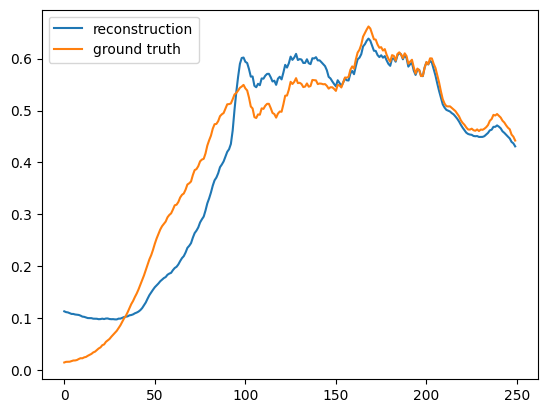

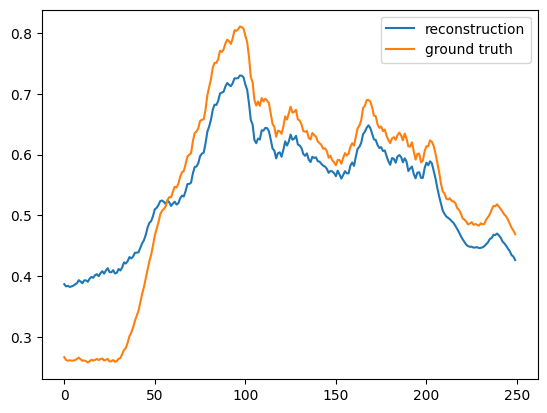

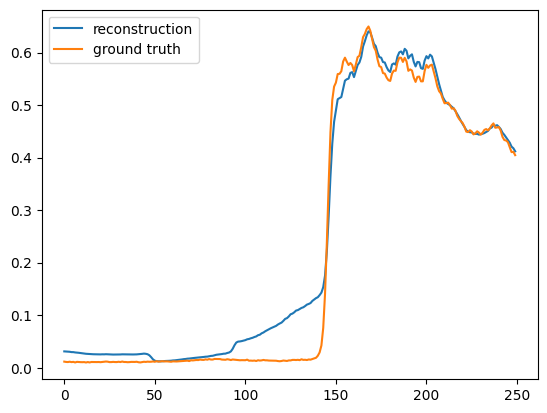

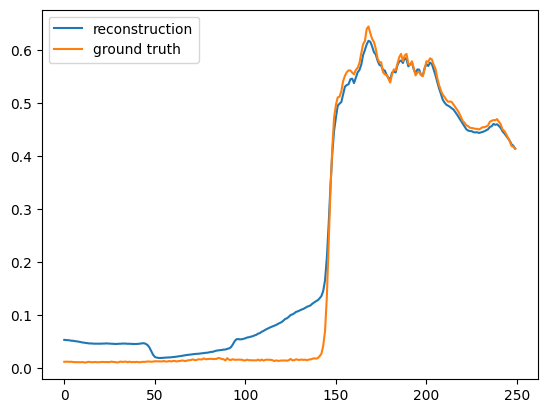

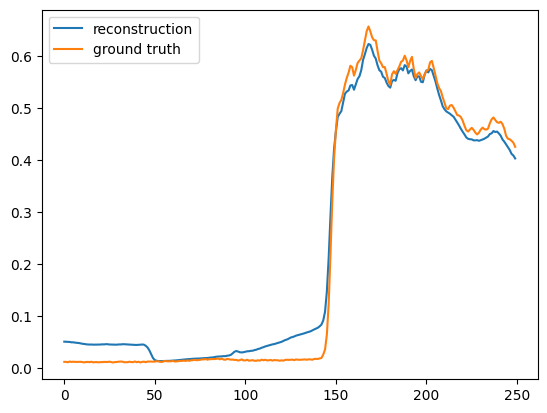

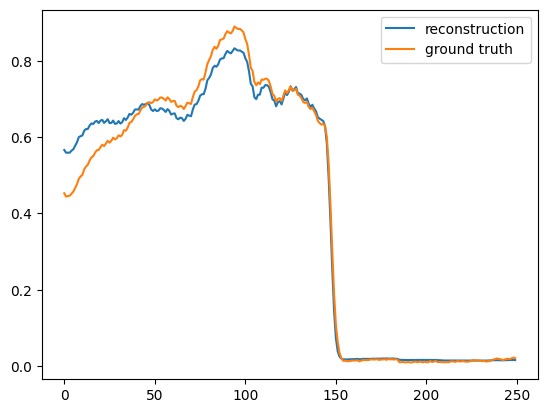

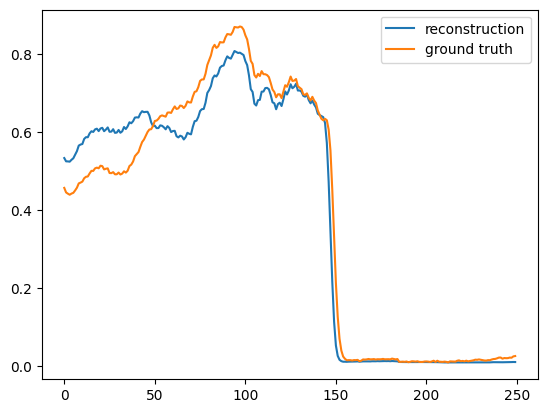

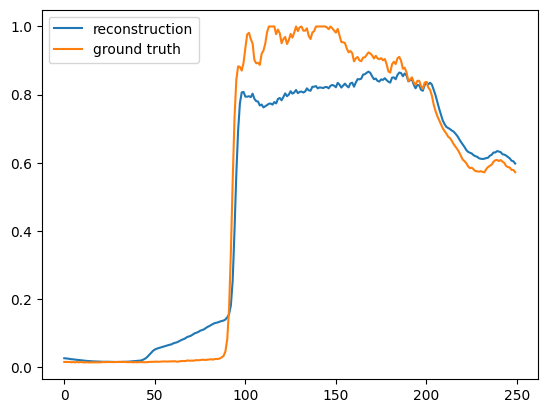

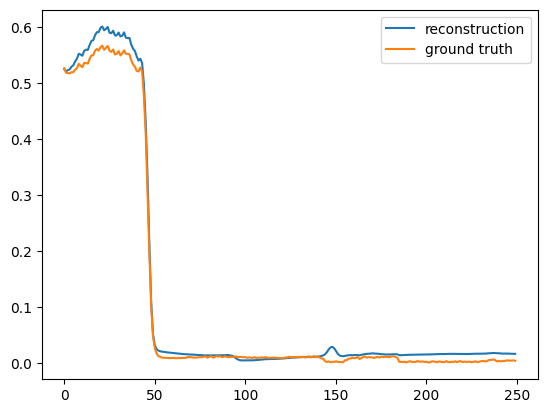

In [7]:
number_figures = 10
import matplotlib.pyplot as plt

indices = torch.randint(0,len(test_data),(number_figures,)).unique()
model = DNNs(device, input_dim=64, output_dim=250, num_dnn=2)
model_state_dict = torch.load(PATH+'num_dnn_'+str(num)+'_model'+str(0))

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)
for i in indices:
    res = test_data[i]
    spec = test_label[i]
    plt.figure(i)
    device = torch.device('cuda:0')
    y_pred  = model(torch.Tensor(res).to(model.device))[-1]
    plt.plot(y_pred.detach().cpu().flatten())
    plt.plot(spec)
    plt.legend(['reconstruction','ground truth'])

In [8]:
from pathlib import Path
PATH = 'saved_model/DNNx2_combined_poisson_10percent/'
num = 2
mdl = DNNs(device, input_dim=64, output_dim=250, num_dnn=2)

from scipy import stats,spatial
#pip install dtw-python
from dtw import *
import torch
import numpy as np
correlation_losses = []
import dcor
def calculate_correlation(model, test_data, test_label):
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    construction = model(test_data_tensor)[-1].detach().cpu().numpy()
   
    # Pearson
    pearson_coefs = []
    pearson_ps = []
    
    # Kendall
    kendall_coefs = []
    kendall_ps = []
    
    # Spearman
    spearman_coefs = []
    spearman_ps = []
    
    # Distance Correlation
    distance_corr = []
    
    #DTW distance
    alignment = []
    
    #absolute_error
    abs_err = []
    
    for i in range(test_label.shape[0]):
        x1 = construction[i,:]
        x2 = test_label[i,:]
        
        res = stats.pearsonr(x1, x2)
        pearson_coefs.append(res[0])
        pearson_ps.append(res[1])
        
        res = stats.kendalltau(x1, x2)
        kendall_coefs.append(res[0])
        kendall_ps.append(res[1])
        
        res = stats.spearmanr(x1, x2)
        spearman_coefs.append(res[0])
        spearman_ps.append(res[1])
        
        distance_corr.append(dcor.distance_correlation(x1,x2))
        
        alignment.append(dtw(x1, x2, distance_only=True).distance)
        abs_err.append(abs(x1-x2))
        
    correlation_results = {
        'pearson': (pearson_coefs, pearson_ps),
        'kendall': (kendall_coefs, kendall_ps),
        'spearman': (spearman_coefs, spearman_ps),
        'DTW': alignment,
        'Absolute Error': abs_err,
        'Distance Correlation': distance_corr
    }

    return correlation_results

for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    # Adding noise to the train and test data
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.0065,std = 0.05, sequence_length=64, noise_seed=i)

    mdl_name = PATH+'num_dnn_2_model'+str(i)
    mdl.load_state_dict(torch.load(mdl_name))
    mdl.eval()
    
    correlation_loss = calculate_correlation(mdl, test_data, test_label)
    correlation_losses.append(correlation_loss)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


In [9]:
for key in correlation_losses[0].keys():
    print(key)
    if key=='Absolute Error':
        errors = []
        for d in correlation_losses:
            errors+=np.concatenate(d[key]).ravel().tolist()
        #percentile
        percentiles = [5, 50, 90, 95, 99]
        for p in percentiles:
            print(p)
            print(np.percentile(errors, p))
    else:
        stat, p = [], []
        for d in correlation_losses:
            if key=='DTW' or key=='Distance Correlation':
                stat+=d[key]
            else:
                stat+=d[key][0]
                p+=d[key][1]
        print(np.mean(stat),np.std(stat))
        if len(p)>0:
            print(np.mean(p),np.std(p))

pearson
0.9150389984612927 0.21316487641752002
0.003381974284902894 0.04697202314300517
kendall
0.6520859880877703 0.21981030323409256
0.003307616250904847 0.043789960669262135
spearman
0.7838066117048603 0.238535148335156
0.0052994972449836196 0.055218163855250524
DTW
8.800935266354111 11.184683152541227
Absolute Error
5
0.0023952433173564263
50
0.026399582483997524
90
0.12886388552834296
95
0.18527098488981047
99
0.3462712284642855
Distance Correlation
0.935532593322495 0.12773449229942657
